In [64]:
import os

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.tree import DecisionTreeRegressor
import optuna

import warnings

#Config
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format
sns.set_style("darkgrid")
colors = sns.color_palette('Set2')

In [4]:
DATASET_DIR = "D:/Datasets/JPX Tokyo Stock Exchange Prediction"
TRAIN_DIR = os.path.join(DATASET_DIR, 'train_files')

In [5]:
%%time

df_prices = pd.read_csv(os.path.join(TRAIN_DIR, 'stock_prices.csv'))
df_prices_sec = pd.read_csv(os.path.join(TRAIN_DIR, 'secondary_stock_prices.csv'))
df_fins = pd.read_csv(os.path.join(TRAIN_DIR, 'financials.csv'))
df_opts = pd.read_csv(os.path.join(TRAIN_DIR, 'options.csv'))
df_trades = pd.read_csv(os.path.join(TRAIN_DIR, 'trades.csv'))
stock_list = pd.read_csv(os.path.join(DATASET_DIR, "stock_list.csv"))

Wall time: 17.3 s


### 1. stock_prices.csv

#### *File Description*<br>
Основной файл, содержащий дневную цену закрытия для каждой акции и столбец с целевой переменной. Далее представлена информация о столбцах, описанных в `stock_price_spec.csv`:

* `RowId`: Уникальный ID записей о ценах, комбинация `Date` и `SecuritiesCode`.
* `Date`: Дата торгов.
* `SecuritiesCode`: Локальный код ценной бумаги.
* `Open`: Цена открытия акции в этот день.
* `High`: Максимальная цена акции за день.
* `Low`: Минимальная цена акции за день.
* `Close`: Цена закрытия акции в этот день.
* `Volume`: Объем торгуемых акций за день.
* `AdjustmentFactor`: Используется для расчета теоретической цены/объема при дроблении/обратном дроблении акций (НЕ включая дивиденды/распределение акций).
* `ExpectedDividend`: Ожидаемая величина дивидендов на текущую дату. Это значение регистрируется за 2 рабочих дня до даты выплаты дивидендов.
* `SupervisionFlag`: Флаг ценных бумаг, находящихся под надзором, и ценных бумаг, подлежащих исключению из списка.
* `Target`: Изменение соотношения скорректированной цены закрытия между t+2 и t+1, где t+0 - дата сделки.

In [6]:
def summarize(df, file_name, n_rows_to_show=5):
    """Обобщенные данные о таблице.
    
    Параметры:
        df: pd.DataFrame
        file_name: str
        n_rows_to_show: int
    """
    print(f"=====Суммарные данные о {file_name}=====")
    print(f"Размер: {df.shape[0]} строк, {df.shape[1]} столбцов")
    
    nan_ratio = pd.isna(df).sum() / len(df) * 100
    nan_ratio.sort_values(ascending=False, inplace=True)
    nan_ratio = nan_ratio.to_frame(name='NaN Ratio').T
    print("Соотношение пропущенных значений по столбцам:")
    display(nan_ratio)   
    print(f"Первые {n_rows_to_show} строк:")
    display(df.head(n_rows_to_show))
    print(f"Количественные данные:")
    display(df.describe())

In [7]:
summarize(df_prices, "stock_prices.csv")

=====Суммарные данные о stock_prices.csv=====
Размер: 2332531 строк, 12 столбцов
Соотношение пропущенных значений по столбцам:


,ExpectedDividend,Open,High,Low,Close,Target,RowId,Date,SecuritiesCode,Volume,AdjustmentFactor,SupervisionFlag
NaN Ratio,99.19,0.33,0.33,0.33,0.33,0.01,0.00,0.00,0.00,0.00,0.00,0.00


Первые 5 строк:


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.00,2755.00,2730.00,2742.00,31400,1.00,NaN,False,0.00
1,20170104_1332,2017-01-04,1332,568.00,576.00,563.00,571.00,2798500,1.00,NaN,False,0.01
2,20170104_1333,2017-01-04,1333,3150.00,3210.00,3140.00,3210.00,270800,1.00,NaN,False,0.01
3,20170104_1376,2017-01-04,1376,1510.00,1550.00,1510.00,1550.00,11300,1.00,NaN,False,0.01
4,20170104_1377,2017-01-04,1377,3270.00,3350.00,3270.00,3330.00,150800,1.00,NaN,False,0.00


Количественные данные:


,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,2332531.00,2324923.00,2324923.00,2324923.00,2324923.00,2332531.00,2332531.00,18865.00,2332293.00
mean,5894.84,2594.51,2626.54,2561.23,2594.02,691936.56,1.00,22.02,0.00
std,2404.16,3577.19,3619.36,3533.49,3576.54,3911255.94,0.07,29.88,0.02
min,1301.00,14.00,15.00,13.00,14.00,0.00,0.10,0.00,-0.58
25%,3891.00,1022.00,1035.00,1009.00,1022.00,30300.00,1.00,5.00,-0.01
50%,6238.00,1812.00,1834.00,1790.00,1811.00,107100.00,1.00,15.00,0.00
75%,7965.00,3030.00,3070.00,2995.00,3030.00,402100.00,1.00,30.00,0.01
max,9997.00,109950.00,110500.00,107200.00,109550.00,643654000.00,20.00,1070.00,1.12


Видно, что в столбце ExpectedDividend 99% значений пропущены. Это объясняется тем, что дивиденты выплачиваются редко

Посмотрим, сколько уникальных дат и акций

In [8]:
n_dates = df_prices['Date'].nunique()
date_min, date_max = df_prices['Date'].min(), df_prices['Date'].max()
n_stocks = df_prices['SecuritiesCode'].nunique()

print(f"Количество уникальных дат: {n_dates} ({date_min} ~ {date_max})\n"
      f"Количество уникальных акций: {n_stocks}")

Количество уникальных дат: 1202 (2017-01-04 ~ 2021-12-03)
Количество уникальных акций: 2000


Посмотрим распределение количества акций к количеству дней, за которые имеются записи о той или иной акции

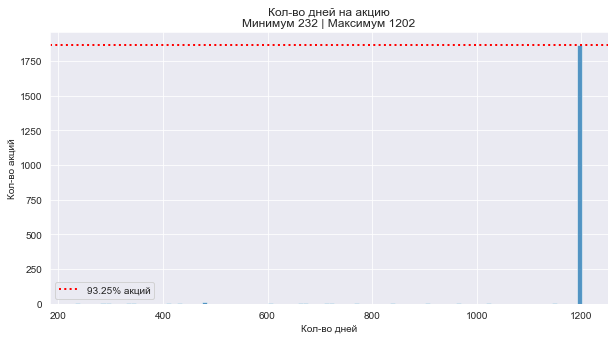

In [33]:
n_dates_per_stock = df_prices.groupby(['SecuritiesCode'])['Date'].count()
stock_cnt_max = (n_dates_per_stock == n_dates_per_stock.max()).sum()
stock_ratio_max = stock_cnt_max / len(n_dates_per_stock) * 100

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=n_dates_per_stock.values, bins=100, palette=colors, ax=ax)
ax.axhline(y=stock_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{stock_ratio_max}% акций')
ax.set_title(f"Кол-во дней на акцию\nМинимум {n_dates_per_stock.min()} | "
             f"Максимум {n_dates_per_stock.max()}")
ax.set_xlabel("Кол-во дней")
ax.set_ylabel("Кол-во акций")
ax.legend()
plt.show()

Примерно 90% акций имеют записи за весь период

Посмотрим распределение количества дней к количеству акций, которые торговались в этот день

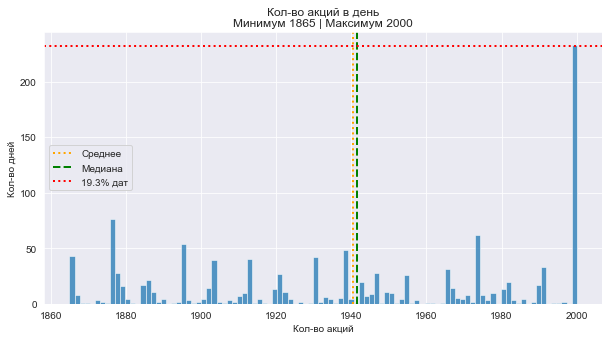

In [29]:
n_stocks_per_date = df_prices.groupby(['Date'])['SecuritiesCode'].count()
date_cnt_max = (n_stocks_per_date == n_stocks_per_date.max()).sum()
date_ratio_max = round(date_cnt_max / len(n_stocks_per_date) * 100, 2)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=n_stocks_per_date.values, bins=100, palette=colors, ax=ax)
ax.axvline(x=n_stocks_per_date.mean(), color='orange', linestyle='dotted',
           linewidth=2, label='Среднее')
ax.axvline(x=n_stocks_per_date.median(), color='green', linestyle='--',
           linewidth=2, label='Медиана')
ax.axhline(y=date_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{date_ratio_max}% дат')
ax.set_title(f"Кол-во акций в день\nМинимум {n_stocks_per_date.min()} | "
             f"Максимум {n_stocks_per_date.max()}")
ax.set_xlabel("Кол-во акций")
ax.set_ylabel("Кол-во дней")
ax.legend()
plt.show()

Примерно только 20% торговых дней имеют записи о всех акциях

#### Работа с пропущенными значениями
Остановимся на записях с пропущенными значениями.

In [35]:
df_no_prices = df_prices[df_prices['Close'].isna()]
print(f"Количество записей без цены: {len(df_no_prices)}")

Количество записей без цены: 7608


Посмотрим кол-во акций с пропущенными ценами по дням

In [39]:
no_prices_per_date = df_no_prices['Date'].value_counts().sort_index()
all_dates = sorted(df_prices['Date'].unique())
no_prices_per_date = no_prices_per_date.reindex(all_dates, fill_value=0)

fig = go.Figure()
fig.add_trace(go.Scatter(x=no_prices_per_date.index, 
                         y=no_prices_per_date, 
                         mode='lines'))
rect_focus_params = {
    'xref': 'x', 'yref': 'y', 'x0': '2020-09-25', 'x1': '2020-10-08',
    'y0': 1900, 'y1': 2000, 'line': {'color': 'red', 'width': 1.5}
}
fig.add_shape(type='rect', **rect_focus_params)
fig.update_layout(
    title=f"Кол-во акций с пропущенными ценами по дням",
    xaxis_title="День",
    yaxis_title="Кол-во акций",
)
fig.show()

Больше всего акций с пропущенными ценами 1 октября 2020 года. Это связано с техническими проблемами на Токийской бирже в этот день

Посмотрим теперь, наоборот, кол-во дней с пропущенными ценами для каждой акции

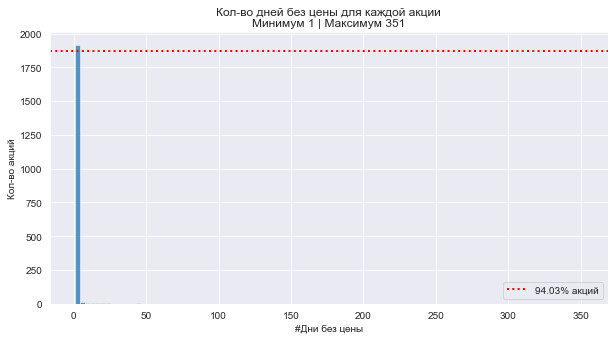

In [48]:
no_prices_per_stock = df_no_prices['SecuritiesCode'].value_counts()
stock_cnt_max = (no_prices_per_stock == no_prices_per_stock.min()).sum()
stock_ratio_max = round(stock_cnt_max / len(no_prices_per_stock) * 100, 2)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=no_prices_per_stock.values, bins=100, palette=colors, ax=ax)
ax.axhline(y=stock_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{stock_ratio_max}% акций')
ax.set_title(f"Кол-во дней без цены для каждой акции\n"
             f"Минимум {no_prices_per_stock.min()} | "
             f"Максимум {no_prices_per_stock.max()}")
ax.set_xlabel("#Дни без цены")
ax.set_ylabel("Кол-во акций")
ax.legend()
plt.show()

#### Исследование целевой переменной

Сделаем функцию, которая для каждой акции строит OHLC (Open, High, Low, Close) график, график изменения объема, а также график изменения целевой переменной

In [74]:
def plot_candle_with_target(stock_code, prime=True):
    """Plot OHLCV plot with target series.
    
    Parameters:
        stock_code: int, код акции
        prime: bool, акция основная или вторичная
    """
    df_ = df_prices.copy() if prime else df_prices_sec.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    dates = df_['Date'].values
    ohlc = {
        'open': df_['Open'].values, 
        'high': df_['High'].values, 
        'low': df_['Low'].values, 
        'close': df_['Close'].values
    }
    vol = df_['Volume'].values
    target = df_['Target'].values
    
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, x_title='Date')
    fig.add_trace(go.Candlestick(x=dates, name='OHLC', **ohlc),
                  row=1, col=1)
    fig.add_trace(go.Bar(x=dates, y=vol, name='Объем (Volume)'),
                  row=2, col=1)
    fig.add_trace(go.Scatter(x=dates, y=target, name='Целевая'),
                  row=3, col=1)
    fig.update_layout(
        title=f"График OHLCV и график целевой переменной (Акция №{stock_code})",
    )
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

In [75]:
for stock_code in df_prices['SecuritiesCode'].unique()[:3]:
    plot_candle_with_target(stock_code)

Посмотрим на среднее распределение целевой переменной

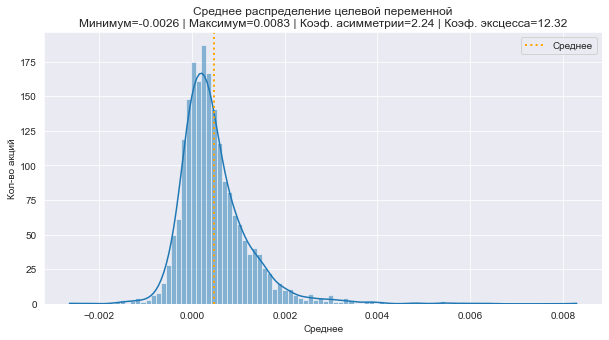

In [87]:
target_mean_per_stock = df_prices.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_mean = target_mean_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_mean_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_mean_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Среднее')
ax.set_title("Среднее распределение целевой переменной\n"
             f"Минимум={round(target_mean_per_stock.min(), 4)} | "
             f"Максимум={round(target_mean_per_stock.max(), 4)} | "
             f"Коэф. асимметрии={round(target_mean_per_stock.skew(), 2)} | "
             f"Коэф. эксцесса={round(target_mean_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Среднее")
ax.set_ylabel("Кол-во акций")
ax.legend()
plt.show()

Среднее значение целевой переменной - это распределение, смещенное вправо. Кроме того, оно имеет большой эксцесс с хвостовыми данными, превышающими хвосты нормального распределения. Для инвесторов высокий эксцесс распределения доходности подразумевает, что инвестор будет время от времени испытывать экстремальную доходность (положительную или отрицательную). Это явление известно как риск эксцесса.

Посмотрим на стандартное распределение целевой переменной

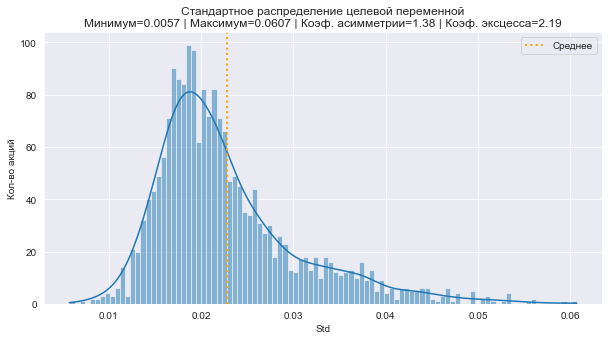

In [82]:
target_std_per_stock = df_prices.groupby(['SecuritiesCode'])['Target'].std()
target_std_mean = target_std_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_std_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_std_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Среднее')
ax.set_title("Стандартное распределение целевой переменной\n"
             f"Минимум={round(target_std_per_stock.min(), 4)} | "
             f"Максимум={round(target_std_per_stock.max(), 4)} | "
             f"Коэф. асимметрии={round(target_std_per_stock.skew(), 2)} | "
             f"Коэф. эксцесса={round(target_std_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Std")
ax.set_ylabel("Кол-во акций")
ax.legend()
plt.show()

Стандартное распределение  целевой переменной снова представляет собой распределение, смещенное вправо, где некоторые акции имеют более высокий std (до 0,06).